# Information retrieval project : Sentiment Analysis

# Naive Bayes & SVM

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import itertools

## Load and Clean Data


In [2]:
# Tokenize a sentence
def clean_str(string, tolower=True):
    """
    Tokenization/string cleaning.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    if tolower:
        string = string.lower()
        
    return string.strip()


# reads the content of the file passed as an argument.
# if limit > 0, this function will return only the first "limit" sentences in the file.
def loadTexts(filename, limit=-1):
    f = open(filename)
    dataset=[]
    line =  f.readline()
    cpt=1
    skip=0
    while line :
        cleanline = clean_str(f.readline())#line
        #cleanline = [b for b in zip(cleanline.split(" ")[:-1], cleanline.split(" ")[1:])]
        #print(cleanline)
        if cleanline: 
            dataset.append(cleanline)
        else: 
            line = f.readline()
            skip+=1
            continue
        if limit > 0 and cpt >= limit: 
            break
        line = f.readline()
        cpt+=1        
        
    f.close()
    print("Load ", cpt, " lines from ", filename , " / ", skip ," lines discarded")
    return dataset


In [3]:
LIM=7000
txtfile = "imdb.pos"  # path of the file containing positive reviews
postxt = loadTexts(txtfile,limit=LIM)
txtfile = "imdb.neg"  # path of the file containing negative reviews
negtxt = loadTexts(txtfile,limit=LIM)

Load  7000  lines from  imdb.pos  /  1  lines discarded
Load  7000  lines from  imdb.neg  /  3  lines discarded


## Split data

There are two files: one with positive reviews (imdb.pos) and one with negative reviews (imdb.neg). Each file contains 300000 reviews, one per line.


The following functions can be used to load and clean the data.

In [6]:
txt = postxt + negtxt # construct the data set
label = list(np.ones(len(postxt), int))+list(np.zeros(len(negtxt), int)) # construct the label set; 1 for positive review and 0 for negative review

In [7]:
from sklearn.model_selection import train_test_split

txt_train, txt_test, label_train, label_test = train_test_split(txt , label , test_size=0.2, random_state = 26 , stratify=label)

## Stop words, constum stop words and term frequency

In [8]:
#download the set of stop words the first time
nltk.download('stopwords')
#Load stop words
stop_words = stopwords.words('english')
#custom_stop_words =['the', 'a', 'of', 'and', 'this', 'it', 'to', 'i', 'is', 'in', 'not']
custom_stop_words =["but","under","no", "not", "very", "so", "too","because", "out", "can"]
#custom_stop_words =  ["not","no"]
Stop_words = [word for word in stop_words if word not in custom_stop_words]
a = [ word for word in postxt if word == "n't"]
stop_pos = []
for i in range(len(txt)) :
    for word in word_tokenize(txt[i]):
        if word in stop_words:
            stop_pos.append(word)
stop_neg = []
for i in range(len(negtxt)) :
    for word in word_tokenize(negtxt[i]):
        if word in stop_words:
            stop_neg.append(word)
#Stop_words_pos = [word for word in word_tokenize(postxt[i]) for i in range(len(postxt)) if word  in stop_words]
#Stop_words_neg = [word for word in negtxt if word  in stop_words]
# Show stop words
from collections import Counter 
def most_frequent(List): 
    occurence_count = Counter(List) 
    return occurence_count.most_common(100)
most_stop_pos = [word for word, freq in most_frequent(stop_pos)]
most_stop_neg = [word for word, freq in most_frequent(stop_neg)]
pos = [word for word in most_stop_pos if word not in most_stop_neg]
neg = [word for word in most_stop_neg if word not in most_stop_pos]
print( most_stop_pos)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['the', 'a', 'of', 'and', 'this', 'it', 'to', 'i', 'is', 'in', 'not', 'for', 'you', 'but', 'an', 'that', 'with', 'what', 'do', 'all', 'was', 'very', 'on', 'as', 'be', 'have', 'my', 'so', 'at', 'just', 'from', 'no', 'more', 'than', 'about', 'your', 'if', 'out', 'me', 'most', 'can', 'are', 'why', 'by', 'should', 'did', 'its', 'too', 'or', 'how', 'up', 'who', 'has', 'does', 'will', 'been', 'they', 'over', 'only', 'there', 'again', 'his', 'some', 'off', 'we', 'had', 'when', 'into', 'were', 'where', 'now', 'any', 'he', 'other', 'am', 'through', 'after', 'being', 's', 'which', 'down', 'those', 'same', 'their', 'once', 'these', 'then', 'because', 'her', 'our', 'here', 'such', 'while', 't', 'd', 'before', 'own', 'them', 'him', 'few']


## Computing  Confusion Matrix

For evaluate methods in later step.

In [16]:
# Confusion Matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    print(thresh)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [17]:
print(len(txt_test))

2800


##  Vectorizing data : Bag-of-words
Label encode the target variable — This is done to transform Categorical data of string type in the data set into numerical values which the model can understand.

https://medium.com/@bedigunjit/simple-guide-to-text-classification-nlp-using-svm-and-naive-bayes-with-python-421db3a72d34 

### Multinomial Naive Bayes

In [18]:
from sklearn import metrics
#1. import and instantiate CountVectorizer (with the default parameters)
from sklearn.feature_extraction.text import CountVectorizer
max_features = [0.2,0.4,0.6,0.8,1.]
max_features = [int(len(txt)*nb_fea) for nb_fea in max_features]
ngrams = [((1,1),"unigram"),((2,2),"bigram"),((3,3),"trigram"),((1,2),"unigram + bigram"),((1,3),"unigram + bigram + trigram")]
Stop_WORDS = [(Stop_words,"WITH CUSTOM STOP WORDS"), (stop_words, "WITHOUT STOP WORDS"),([], "WITH STOP WORDS")]
for ngram, desc in ngrams :
    print("------------------------------------------------------")
    print("IN THE CASE OF :: ", desc)
    for stp_word,descr in Stop_WORDS:
        print("------------------------------------------------------")
        print("RESULTS ", descr)
        for max_feat in max_features:
            # 2. instantiate CountVectorizer (vectorizer)
            vect = CountVectorizer(stop_words = stp_word, ngram_range=ngram, max_features = max_feat)
            # CountVectorizer() will output a sparse matrix
            # 3. fit
            # learn the 'vocabulary' of the training data (occurs in-place)
            vect.fit(txt_train)
            # examine the fitted vocabulary
            #vect.get_feature_names()
            # 4. transform training data into a 'document-term matrix'
            simple_train_dtm = vect.transform(txt_train)

            # 5. transform testing data into a document-term matrix (using existing vocabulary)
            simple_test_dtm = vect.transform(txt_test)
            # examine the vocabulary and document-term matrix together
            #pd.DataFrame(simple_test_dtm.toarray()[:20,], columns=vect.get_feature_names())
            nb = naive_bayes.MultinomialNB()
            # 6. train the model 
            # using X_train_dtm (timing it with an IPython "magic command")
            %time nb.fit(simple_train_dtm, label_train)
            # 7. make class predictions for X_test_dtm
            y_pred_class = nb.predict(simple_test_dtm)
            # 8. calculate accuracy of class predictions
            acc = metrics.accuracy_score(label_test, y_pred_class) * 100
            print("nb_features = ", max_feat, "test accuracy = %.3f" %acc,"%")

------------------------------------------------------
IN THE CASE OF ::  unigram
------------------------------------------------------
RESULTS  WITH CUSTOM STOP WORDS
Wall time: 2.99 ms
nb_features =  2800 test accuracy = 77.250 %
Wall time: 4.99 ms
nb_features =  5600 test accuracy = 77.821 %
Wall time: 2.99 ms
nb_features =  8400 test accuracy = 78.071 %
Wall time: 4 ms
nb_features =  11200 test accuracy = 78.071 %
Wall time: 4.99 ms
nb_features =  14000 test accuracy = 78.071 %
------------------------------------------------------
RESULTS  WITHOUT STOP WORDS
Wall time: 4.96 ms
nb_features =  2800 test accuracy = 76.714 %
Wall time: 5.01 ms
nb_features =  5600 test accuracy = 77.393 %
Wall time: 6.07 ms
nb_features =  8400 test accuracy = 77.679 %
Wall time: 3.99 ms
nb_features =  11200 test accuracy = 77.679 %
Wall time: 20.6 ms
nb_features =  14000 test accuracy = 77.679 %
------------------------------------------------------
RESULTS  WITH STOP WORDS
Wall time: 4.99 ms
nb_featu

Wall time: 2.99 ms
Confusion matrix, without normalization
[[1137  263]
 [ 313 1087]]
568.5


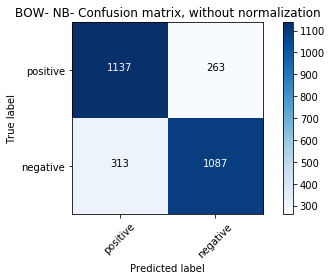

In [144]:
#Confusion Matrix for the best result 
#######SVM-for the best hyperparameters#######
max_feat = int(0.8 * len(txt))
ngram = (1,1) 
vect = CountVectorizer(stop_words = [], ngram_range=ngram, max_features = max_feat)
vect.fit(txt_train)
simple_train_dtm = vect.transform(txt_train)
simple_test_dtm = vect.transform(txt_test)
nb = naive_bayes.MultinomialNB()
%time nb.fit(simple_train_dtm, label_train)
y_pred_class = nb.predict(simple_test_dtm)
##############################################
from sklearn.metrics import confusion_matrix
# Compute confusion matrix
cnf_matrix_NB_BOW = confusion_matrix(label_test, y_pred_class)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_NB_BOW, classes=["positive", "negative"], title="BOW- NB- Confusion matrix, without normalization")
plt.show()

### SVM

In [30]:
from sklearn import metrics
#1. import and instantiate CountVectorizer (with the default parameters)
from sklearn.feature_extraction.text import CountVectorizer
max_features = [0.2,0.4,0.6,0.8,1.]
max_features = [int(len(txt)*nb_fea) for nb_fea in max_features]
ngrams = [((1,1),"unigram"),((2,2),"bigram"),((3,3),"trigram"),((1,2),"unigram + bigram"),((1,3),"unigram + bigram + trigram")]
Stop_WORDS = [(Stop_words,"WITH CUSTOM STOP WORDS"), (stop_words, "WITHOUT STOP WORDS"),([], "WITH STOP WORDS")]
for ngram, desc in ngrams :
    print("------------------------------------------------------")
    print("IN THE CASE OF :: ", desc)
    for stp_word,descr in Stop_WORDS:
        print("------------------------------------------------------")
        print("RESULTS ", descr)
        for max_feat in max_features:
            # 2. instantiate CountVectorizer (vectorizer)
            #max_features = int(len(txt)*95/100)
            vect = CountVectorizer(stop_words = stp_word, ngram_range=ngram, max_features = max_feat)
            # 3. fit
            # learn the 'vocabulary' of the training data (occurs in-place)
            vect.fit(txt_train)
            # 4. transform training data into a 'document-term matrix'
            simple_train_dtm = vect.transform(txt_train)
            # 5. transform testing data into a document-term matrix (using existing vocabulary)
            simple_test_dtm = vect.transform(txt_test)
            # 6. make class predictions for X_test_dtm
            SVM = svm.SVC(C=1.0, kernel='linear', degree=4, gamma='auto')
            # 7. train the model 
            # using X_train_dtm (timing it with an IPython "magic command")
            %time  SVM.fit(simple_train_dtm,label_train)
            predictions_SVM = SVM.predict(simple_test_dtm)
            # calculate accuracy of class predictions
            acc = metrics.accuracy_score(label_test, predictions_SVM) * 100
            print("nb_features = ", max_feat, "SVM Accuracy Score -> %.3f" %acc, "%")

------------------------------------------------------
IN THE CASE OF ::  unigram
------------------------------------------------------
RESULTS  WITH CUSTOM STOP WORDS
Wall time: 5.15 s
nb_features =  2800 SVM Accuracy Score -> 77.714 %
Wall time: 6.09 s
nb_features =  5600 SVM Accuracy Score -> 78.179 %
Wall time: 7.51 s
nb_features =  8400 SVM Accuracy Score -> 78.500 %
Wall time: 9.01 s
nb_features =  11200 SVM Accuracy Score -> 78.500 %
Wall time: 11.5 s
nb_features =  14000 SVM Accuracy Score -> 78.500 %
------------------------------------------------------
RESULTS  WITHOUT STOP WORDS
Wall time: 8.83 s
nb_features =  2800 SVM Accuracy Score -> 77.000 %
Wall time: 7.28 s
nb_features =  5600 SVM Accuracy Score -> 77.321 %
Wall time: 6.08 s
nb_features =  8400 SVM Accuracy Score -> 77.607 %
Wall time: 7.04 s
nb_features =  11200 SVM Accuracy Score -> 77.607 %
Wall time: 7.1 s
nb_features =  14000 SVM Accuracy Score -> 77.607 %
------------------------------------------------------


Wall time: 9.4 s
Confusion matrix, without normalization
[[1130  270]
 [ 317 1083]]
565.0


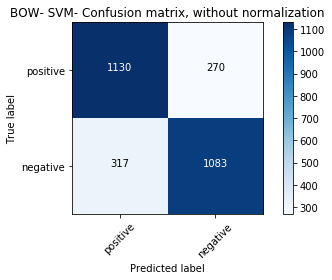

In [135]:
#Confusion Matrix for the best result 
#######SVM-for the best hyperparameters#######
max_feat = int(1. * len(txt))
ngram = (1,2) 
vect = CountVectorizer(stop_words = [], ngram_range=ngram, max_features = max_feat)
vect.fit(txt_train)
simple_train_dtm = vect.transform(txt_train)
simple_test_dtm = vect.transform(txt_test)
SVM = svm.SVC(C=1.0, kernel='linear', degree=4, gamma='auto')
%time  SVM.fit(simple_train_dtm,label_train)
predictions_SVM = SVM.predict(simple_test_dtm)
##############################################
from sklearn.metrics import confusion_matrix
# Compute confusion matrix
cnf_matrix_SVM_BOW = confusion_matrix(label_test, predictions_SVM)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_SVM_BOW, classes=["positive", "negative"], title="BOW- SVM- Confusion matrix, without normalization")
plt.show()

##  Vectorizing data : TF-IDF

### Naive Bayes

In [31]:
from sklearn import metrics
#1. import and instantiate CountVectorizer (with the default parameters)
from sklearn.feature_extraction.text import CountVectorizer
max_features = [0.2,0.4,0.6,0.8,1.]
max_features = [int(len(txt)*nb_fea) for nb_fea in max_features]
ngrams = [((1,1),"unigram"),((2,2),"bigram"),((3,3),"trigram"),((1,2),"unigram + bigram"),((2,3),"bigram + trigram"),((1,3),"unigram + bigram + trigram")]
Stop_WORDS = [(Stop_words,"WITH CUSTOM STOP WORDS"), (stop_words, "WITHOUT STOP WORDS"),([], "WITH STOP WORDS")]
for ngram, desc in ngrams :
    print("------------------------------------------------------")
    print("IN THE CASE OF :: ", desc)
    for stp_word,descr in Stop_WORDS:
        print("------------------------------------------------------")
        print("RESULTS ", descr)
        for max_feat in max_features:
            Encoder = LabelEncoder()
            Train_Y = Encoder.fit_transform(label_train)
            Test_Y = Encoder.fit_transform(label_test)
            Tfidf_vect = TfidfVectorizer(stop_words = stp_word, ngram_range=ngram, max_features = max_feat)
            Tfidf_vect.fit(txt)
            Train_X_Tfidf = Tfidf_vect.transform(txt_train)
            Test_X_Tfidf = Tfidf_vect.transform(txt_test)
            # fit the training dataset on the NB classifier
            Naive = naive_bayes.MultinomialNB()
            Naive.fit(Train_X_Tfidf,Train_Y)
            # predict the labels on validation dataset
            predictions_NB = Naive.predict(Test_X_Tfidf)
            # Use accuracy_score function to get the accuracy
            acc = metrics.accuracy_score(label_test, predictions_NB) * 100
            print("nb_features = ", max_feat, "Naive Bayes Accuracy Score -> %.3f" %acc, "%")

------------------------------------------------------
IN THE CASE OF ::  unigram
------------------------------------------------------
RESULTS  WITH CUSTOM STOP WORDS
nb_features =  2800 Naive Bayes Accuracy Score -> 77.214 %
nb_features =  5600 Naive Bayes Accuracy Score -> 77.393 %
nb_features =  8400 Naive Bayes Accuracy Score -> 77.464 %
nb_features =  11200 Naive Bayes Accuracy Score -> 77.464 %
nb_features =  14000 Naive Bayes Accuracy Score -> 77.464 %
------------------------------------------------------
RESULTS  WITHOUT STOP WORDS
nb_features =  2800 Naive Bayes Accuracy Score -> 76.929 %
nb_features =  5600 Naive Bayes Accuracy Score -> 77.250 %
nb_features =  8400 Naive Bayes Accuracy Score -> 77.071 %
nb_features =  11200 Naive Bayes Accuracy Score -> 77.107 %
nb_features =  14000 Naive Bayes Accuracy Score -> 77.107 %
------------------------------------------------------
RESULTS  WITH STOP WORDS
nb_features =  2800 Naive Bayes Accuracy Score -> 78.321 %
nb_features =  

Text(0.5,0,'#features')

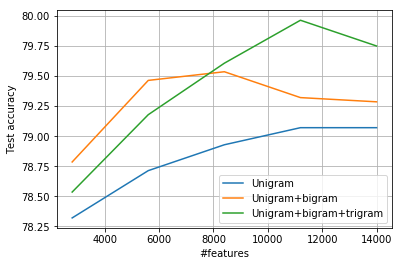

In [11]:
unigrams_acc = [78.321,78.714, 78.929, 79.071, 79.071]
bigrams_acc = [78.786, 79.464, 79.536, 79.321, 79.286]
trigrams_acc = [78.536, 79.179, 79.607, 79.964, 79.750]
max_features = [0.2,0.4,0.6,0.8,1.]
max_features = [int(len(txt)*nb_fea) for nb_fea in max_features]

plt.plot(max_features,unigrams_acc,label='Unigram' )
plt.plot(max_features,bigrams_acc,label='Unigram+bigram' )
plt.plot(max_features,trigrams_acc,label='Unigram+bigram+trigram' )
plt.legend()
plt.grid(which='both')
plt.ylabel("Test accuracy")
plt.xlabel(("#features"))

Confusion matrix, without normalization
[[1111  289]
 [ 272 1128]]
564.0


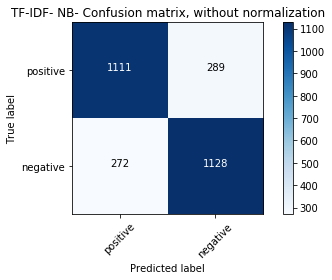

In [145]:
#Confusion Matrix for the best result 
####### NB-for the best hyperparameters#######
max_feat = int(0.8 * len(txt))
ngram = (1,3) 
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(label_train)
Test_Y = Encoder.fit_transform(label_test)
Tfidf_vect = TfidfVectorizer(stop_words = stp_word, ngram_range=ngram, max_features = max_feat)
Tfidf_vect.fit(txt)
Train_X_Tfidf = Tfidf_vect.transform(txt_train)
Test_X_Tfidf = Tfidf_vect.transform(txt_test)
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)
##############################################
from sklearn.metrics import confusion_matrix
# Compute confusion matrix
cnf_matrix_NB_TFIDF = confusion_matrix(label_test, predictions_NB)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_NB_TFIDF, classes=["positive", "negative"], title="TF-IDF- NB- Confusion matrix, without normalization")
plt.show()

### SVM

In [32]:
from sklearn import metrics
#1. import and instantiate CountVectorizer (with the default parameters)
from sklearn.feature_extraction.text import CountVectorizer
max_features = [0.2,0.4,0.6,0.8,1.]
max_features = [int(len(txt)*nb_fea) for nb_fea in max_features]
ngrams = [((1,1),"unigram"),((2,2),"bigram"),((3,3),"trigram"),((1,2),"unigram + bigram"),((1,3),"unigram + bigram + trigram")]
Stop_WORDS = [(Stop_words,"WITH CUSTOM STOP WORDS"), (stop_words, "WITHOUT STOP WORDS"),([], "WITH STOP WORDS")]
for ngram, desc in ngrams :
    print("------------------------------------------------------")
    print("IN THE CASE OF :: ", desc)
    for stp_word,descr in Stop_WORDS:
        print("------------------------------------------------------")
        print("RESULTS ", descr)
        for max_feat in max_features:
            Encoder = LabelEncoder()
            Train_Y = Encoder.fit_transform(label_train)
            Test_Y = Encoder.fit_transform(label_test)
            Tfidf_vect = TfidfVectorizer(stop_words = stp_word, ngram_range=ngram, max_features = max_feat)
            Tfidf_vect.fit(txt)
            Train_X_Tfidf = Tfidf_vect.transform(txt_train)
            Test_X_Tfidf = Tfidf_vect.transform(txt_test)
            # Classifier - Algorithm - SVM
            # fit the training dataset on the classifier
            SVM = svm.SVC(C=1.0, kernel='linear', degree=4, gamma='auto')
            SVM.fit(Train_X_Tfidf,Train_Y)
            # predict the labels on validation dataset
            predictions_SVM = SVM.predict(Test_X_Tfidf)
            # Use accuracy_score function to get the accuracy
            acc = metrics.accuracy_score(label_test, predictions_SVM) * 100
            print("nb_features = ", max_feat, "SVM Accuracy Score -> %.3f" %acc, "%")

------------------------------------------------------
IN THE CASE OF ::  unigram
------------------------------------------------------
RESULTS  WITH CUSTOM STOP WORDS
nb_features =  2800 SVM Accuracy Score -> 78.286 %
nb_features =  5600 SVM Accuracy Score -> 78.714 %
nb_features =  8400 SVM Accuracy Score -> 79.000 %
nb_features =  11200 SVM Accuracy Score -> 78.857 %
nb_features =  14000 SVM Accuracy Score -> 78.857 %
------------------------------------------------------
RESULTS  WITHOUT STOP WORDS
nb_features =  2800 SVM Accuracy Score -> 77.964 %
nb_features =  5600 SVM Accuracy Score -> 77.857 %
nb_features =  8400 SVM Accuracy Score -> 77.929 %
nb_features =  11200 SVM Accuracy Score -> 77.821 %
nb_features =  14000 SVM Accuracy Score -> 77.821 %
------------------------------------------------------
RESULTS  WITH STOP WORDS
nb_features =  2800 SVM Accuracy Score -> 79.107 %
nb_features =  5600 SVM Accuracy Score -> 79.357 %
nb_features =  8400 SVM Accuracy Score -> 79.321 %
n

Text(0.5,0,'#features')

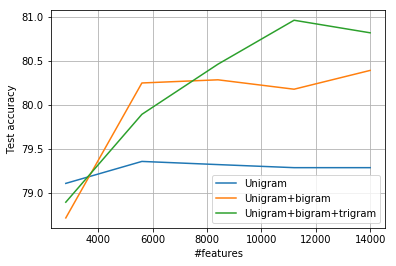

In [10]:
unigrams_acc = [79.107,79.357 , 79.321, 79.286, 79.286]
bigrams_acc = [78.714, 80.250, 80.286, 80.179, 80.393]
trigrams_acc = [78.893, 79.893, 80.464, 80.964, 80.821]
max_features = [0.2,0.4,0.6,0.8,1.]
max_features = [int(len(txt)*nb_fea) for nb_fea in max_features]

plt.plot(max_features,unigrams_acc,label='Unigram' )
plt.plot(max_features,bigrams_acc,label='Unigram+bigram' )
plt.plot(max_features,trigrams_acc,label='Unigram+bigram+trigram' )
plt.legend()
plt.grid(which='both')
plt.ylabel("Test accuracy")
plt.xlabel(("#features"))

Confusion matrix, without normalization
[[1140  260]
 [ 277 1123]]
570.0


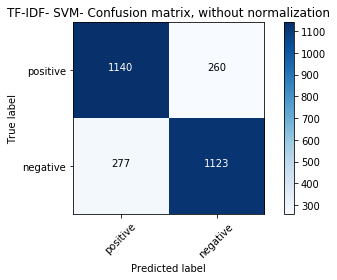

In [23]:
#Confusion Matrix for the best result 
#######SVM-for the best hyperparameters#######
max_feat = int(0.8 * len(txt))
ngram = (1,3) 
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(label_train)
Test_Y = Encoder.fit_transform(label_test)
Tfidf_vect = TfidfVectorizer(stop_words = [], ngram_range=ngram, max_features = max_feat)
Tfidf_vect.fit(txt)
Train_X_Tfidf = Tfidf_vect.transform(txt_train)
Test_X_Tfidf = Tfidf_vect.transform(txt_test)
SVM = svm.SVC(C=1.0, kernel='linear', degree=4, gamma='auto')
SVM.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
##############################################
# Compute confusion matrix
cnf_matrix_SVM_TFIDF = confusion_matrix(label_test, predictions_SVM)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_SVM_TFIDF, classes=["positive", "negative"], title="TF-IDF- SVM- Confusion matrix, without normalization")
plt.show()